In [1]:
from imports import *
from datasets.dent import *
import pickle
from cfg import *

In [2]:
labels = {'Unknown':0, 'Dent': 1}

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features,num_classes)
    return model.cpu()

def plot_from_image_preds(img,total_preds):
    fig,ax = plt.subplots(1)
    for i in range(len(total_preds)):
        xy = total_preds[i]['boxes'][0],total_preds[i]['boxes'][1]
        width = total_preds[i]['boxes'][2]-total_preds[i]['boxes'][0]
        height = total_preds[i]['boxes'][3]-total_preds[i]['boxes'][1]
        rect = patches.Rectangle(xy,width,height,linewidth=1,edgecolor='r',facecolor='none')
        ax.text(xy[0],xy[1],labels[total_preds[i]['labels'].item()])
        ax.add_patch(rect)
    ax.imshow(img)
    
model = get_model(len(labels))

In [4]:
#checkpoint = torch.load('saved_models/sideRight.pth')
checkpoint = torch.load('saved_models/dent_3.pth')
model.load_state_dict(checkpoint['model'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#epoch = checkpoint['epoch']

<All keys matched successfully>

In [5]:
with open("datalists/dent_images_path_list.txt", "rb") as fp:
    val_img_paths = pickle.load(fp)
    
test_paths = []
with open(os.path.join(dent_path,'valid.txt')) as f:
    test_paths = f.readlines()

for i in range(len(test_paths)):
    test_paths[i] = test_paths[i].strip('\n')
    test_paths[i] = test_paths[i]+'.jpg'
    img_dir = os.path.join(dent_path,'images')
    test_paths[i] = os.path.join(img_dir,test_paths[i])

In [7]:
def get_preds(idx,img_datalist):
    im0 = Image.open(img_datalist[idx])
    im0_tensor = torchvision.transforms.ToTensor()(im0);
    pred = model([im0_tensor.cuda()])
    total_preds = []
    for n,confidence in enumerate(pred[0]['scores']):
        if confidence>0.75:
            pred_update = {}
            pred_update['boxes'] = pred[0]['boxes'][n]
            pred_update['labels'] = pred[0]['labels'][n]
            pred_update['scores'] = pred[0]['scores'][n]
            total_preds.append(pred_update)
    return im0,total_preds

In [8]:
# Run it only once
model.eval();
model.cuda();

In [9]:
labels = {k:v for v,k in labels.items()}

#### we can predict for test_paths but due to GPU, we are predicting some images(giving indices)

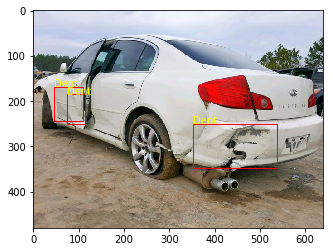

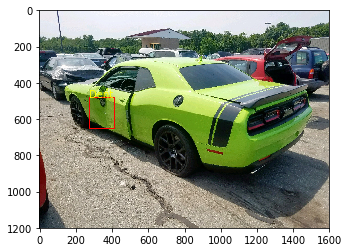

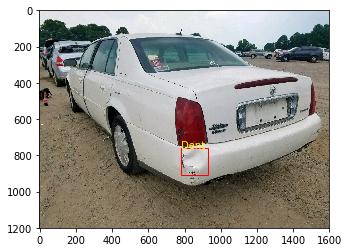

In [10]:
im_list = [209,99,0] # indices
for i in im_list:
    im, total_preds = get_preds(i,val_img_paths) # can give test_paths but change code in get_preds
    plot_from_image_preds(im,total_preds)